<a href="https://colab.research.google.com/github/dacardonave/Modelo_Desercion_Clientes_De_Una_Empresa/blob/main/Modelo_Desercion_Clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba tecnica Ingeniero de Datos – Comercial Nutresa 2021

### Daniel Cardona Velasquez

## Planteamiento del reto

###### La compañía para la cual trabaja desea contar con una herramienta que le permita identificar anticipadamente los clientes que se van a retirar en el siguiente periodo, con el objetivo de implementar planes de acción que logren reducir este comportamiento tanto como sea posible. Por este motivo, se le ha encargado construir un modelo que a partir de la base de datos suministrada permita predecir, con la mayor precisión posible, la variable “Retiro”.

###### Para cumplir con este reto debe dar respuesta a las preguntas y lineamientos que se indican a continuación:

* Realice un análisis descriptivo de los datos, depure y seleccione las variables que considere más importantes.
*	Defina que indicador debe usar para medir la precisión del modelo y la metodología de validación a seguir.
*	Entrene y valide los modelos que considere necesarios y seleccione el mejor con base en sus criterios.
*	Plantee un plan de trabajo de puesta en marcha y administración del modelo.
*	Envíe un archivo Markdown o Jupyter Notebook que responda a cada uno de los puntos anteriores, debidamente argumentado y en el cual se explique el paso a paso realizado.


### Librerias 

In [1]:
#Para admitir python 2 y python 3
from __future__ import division, print_function, unicode_literals

# Importo las librerias a usar
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle as pk
import numpy as np
from sklearn.metrics import confusion_matrix
import joblib
import os
from joblib import dump

#Ignora las advertencias inútiles
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Importacion de los datos y lectura de los datos


In [2]:
BD = pd.read_csv('Data.csv', sep=";", encoding='utf-8', decimal = ',' )

## Datos 

Se observan 63 variables y la etiqueta de salida (Retiro) a predecir

In [3]:
BD.head(10)

,Id,Lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,reloads_inactive_days,reloads_count,reloads_sum,calls_outgoing_count,calls_outgoing_spendings,calls_outgoing_duration,calls_outgoing_spendings_max,calls_outgoing_duration_max,calls_outgoing_inactive_days,calls_outgoing_to_onnet_count,calls_outgoing_to_onnet_spendings,calls_outgoing_to_onnet_duration,calls_outgoing_to_onnet_inactive_days,calls_outgoing_to_offnet_count,calls_outgoing_to_offnet_spendings,calls_outgoing_to_offnet_duration,calls_outgoing_to_offnet_inactive_days,calls_outgoing_to_abroad_count,calls_outgoing_to_abroad_spendings,calls_outgoing_to_abroad_duration,calls_outgoing_to_abroad_inactive_days,sms_outgoing_count,sms_outgoing_spendings,sms_outgoing_spendings_max,sms_outgoing_inactive_days,sms_outgoing_to_onnet_count,sms_outgoing_to_onnet_spendings,sms_outgoing_to_onnet_inactive_days,sms_outgoing_to_offnet_count,sms_outgoing_to_offnet_spendings,sms_outgoing_to_offnet_inactive_days,sms_outgoing_to_abroad_count,sms_outgoing_to_abroad_spendings,sms_outgoing_to_abroad_inactive_days,sms_incoming_count,sms_incoming_spendings,sms_incoming_from_abroad_count,sms_incoming_from_abroad_spendings,gprs_session_count,gprs_usage,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,Retiro
0,13,1000,0,1,0.05,0.00,1,1,0,0,66,0,0.00,27,0.00,1.02,0.00,0.58,1,2,0.00,0.0,1,6,0.00,0.00,1,0,0.00,0.00,1,6,0.00,0.00,5,0,0.0,5,5,0.00,5,0,0.0,5,18,0.0,0,0.0,0,0.0,0.0,1276,4,12.01,75.27,0.00,63.43,0.00,210,1,84,0,0.00,0
1,14,1000,0,25,28.31,3.45,1,0,0,0,1276,0,0.00,5,3.45,9.90,1.51,4.33,25,5,3.45,9.9,25,0,0.00,0.00,25,5,3.45,9.90,25,0,0.00,0.00,1276,0,0.0,1276,0,0.00,1276,0,0.0,1276,0,0.0,0,0.0,0,0.0,0.0,1276,0,0.00,13.38,11.18,2.00,11.18,0,0,0,0,0.00,0
2,18,1005,0,8,15.62,1.97,1,0,0,0,1276,0,0.00,18,1.97,14.92,0.89,9.23,8,0,0.00,0.0,8,0,0.00,0.00,8,6,1.31,10.45,8,0,0.00,0.00,1276,0,0.0,1276,0,0.00,1276,0,0.0,1276,7,0.0,4,0.0,0,0.0,0.0,1276,0,0.00,30.00,0.00,0.00,10.45,0,0,0,0,0.00,0
3,27,1013,0,11,5.62,0.00,1,0,0,0,1276,0,0.00,1,0.00,0.00,0.00,0.00,11,0,0.00,0.0,11,0,0.00,0.00,11,0,0.00,0.00,11,0,0.00,0.00,1276,0,0.0,1276,0,0.00,1276,0,0.0,1276,0,0.0,0,0.0,0,0.0,0.0,1276,0,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.00,1
4,32,1032,0,2,5.86,0.15,1,0,0,1,17,1,6.00,22,0.15,2.58,0.15,1.00,2,0,0.00,0.0,2,4,0.15,1.00,2,0,0.00,0.00,2,0,0.00,0.00,1276,0,0.0,1276,0,0.00,1276,0,0.0,1276,5,0.0,0,0.0,0,0.0,0.0,1276,1,6.00,2.58,0.00,1.00,0.00,0,0,0,0,0.00,0
5,35,1039,0,1,12.51,12.96,1,1,0,1,6,1,17.00,56,12.96,90.73,2.39,15.95,1,0,0.00,0.0,1,15,8.44,56.28,1,0,0.00,0.00,1,2,0.00,0.00,6,0,0.0,6,0,0.00,6,0,0.0,6,11,0.0,0,0.0,0,0.0,0.0,1276,3,29.00,356.65,0.00,215.83,0.00,4,1,1,0,0.00,0
6,36,1040,0,1,16.73,2.34,1,1,0,1,4,1,12.00,8,0.00,0.00,0.00,0.00,5,0,0.00,0.0,5,0,0.00,0.00,5,0,0.00,0.00,5,41,2.34,0.06,1,0,0.0,1,39,2.34,1,0,0.0,1,4,0.0,0,0.0,0,0.0,0.0,1276,1,12.00,0.00,0.00,0.00,0.00,112,0,109,0,0.00,0
7,47,521,0,1,0.66,45.89,1,1,0,1,2,11,48.00,395,32.93,253.33,2.30,15.35,1,0,0.00,0.0,1,129,25.89,172.60,1,0,0.00,0.00,1,246,12.96,0.06,1,0,0.0,1,215,12.72,1,0,0.0,1,107,0.0,0,0.0,0,0.0,0.0,1276,35,158.00,735.87,0.00,473.50,0.00,1123,0,1006,0,0.00,0
8,52,824,0,2,4.49,1.37,1,1,0,1,27,1,12.02,20,1.37,10.77,0.40,2.68,4,0,0.00,0.0,4,14,1.22,8.10,4,0,0.00,0.00,4,36,0.00,0.00,2,0,0.0,2,0,0.00,2,0,0.0,2,10,6.0,0,0.0,0,0.0,0.0,57,6,30.03,56.22,0.00,48.02,0.00,122,1,1,0,2.77,0
9,59,867,0,2,90.93,17.99,1,1,0,1,12,1,72.06,88,17.99,121.53,4.09,27.27,2,0,0.00,0.0,2,14,17.99,119.95,2,0,0.00,0.00,2,16,0.00,0.00,4,0,0.0,4,16,0.00,4,0,0.0,4,3,0.0,0,0.0,0,0.0,0.0,1276,7,10

## Análisis descriptivo y exploratorio


In [4]:
# Tamaño del dataset
print(BD.shape)

(66469, 64)


In [5]:
# Informacion sobre tipo y cantidad de los datos
BD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66469 entries, 0 to 66468
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Id                                          66469 non-null  int64  
 1   Lifetime                                    66469 non-null  int64  
 2   user_intake                                 66469 non-null  int64  
 3   user_no_outgoing_activity_in_days           66469 non-null  int64  
 4   user_account_balance_last                   66469 non-null  float64
 5   user_spendings                              66469 non-null  float64
 6   user_has_outgoing_calls                     66469 non-null  int64  
 7   user_has_outgoing_sms                       66469 non-null  int64  
 8   user_use_gprs                               66469 non-null  int64  
 9   user_does_reload                            66469 non-null  int64  
 10  reloads_in

In [6]:
# Estadisticas basica de las vairbales
BD.describe()

,Id,Lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,reloads_inactive_days,reloads_count,reloads_sum,calls_outgoing_count,calls_outgoing_spendings,calls_outgoing_duration,calls_outgoing_spendings_max,calls_outgoing_duration_max,calls_outgoing_inactive_days,calls_outgoing_to_onnet_count,calls_outgoing_to_onnet_spendings,calls_outgoing_to_onnet_duration,calls_outgoing_to_onnet_inactive_days,calls_outgoing_to_offnet_count,calls_outgoing_to_offnet_spendings,calls_outgoing_to_offnet_duration,calls_outgoing_to_offnet_inactive_days,calls_outgoing_to_abroad_count,calls_outgoing_to_abroad_spendings,calls_outgoing_to_abroad_duration,calls_outgoing_to_abroad_inactive_days,sms_outgoing_count,sms_outgoing_spendings,sms_outgoing_spendings_max,sms_outgoing_inactive_days,sms_outgoing_to_onnet_count,sms_outgoing_to_onnet_spendings,sms_outgoing_to_onnet_inactive_days,sms_outgoing_to_offnet_count,sms_outgoing_to_offnet_spendings,sms_outgoing_to_offnet_inactive_days,sms_outgoing_to_abroad_count,sms_outgoing_to_abroad_spendings,sms_outgoing_to_abroad_inactive_days,sms_incoming_count,sms_incoming_spendings,sms_incoming_from_abroad_count,sms_incoming_from_abroad_spendings,gprs_session_count,gprs_usage,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,Retiro
count,6.646900e+04,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000,66469.000000
mean,5.948572e+05,4006.037867,0.040365,63.975718,9.645420,6.845812,0.804450,0.603229,0.045074,0.560246,361.313515,0.934917,7.791202,35.334562,4.782323,32.223352,0.874959,4.797301,197.809686,0.317170,0.155738,0.401333,197.809686,16.312913,2.933424,21.272680,197.809686,1.477937,0.304492,1.183333,197.809686,34.366622,1.866149,0.086134,411.987408,2.500038,0.126320,411.987408,21.491583,1.255409,411.987408,1.016775,0.127628,411.987408,8.954385,0.118772,0.797560,0.001301,6.329492,1.799585,0.197343,1187.918097,3.347500,21.900539,98.757451,1.023373,66.910263,3.037600,101.418105,7.318630,62.272684,3.062616,5.931800,0.209225
std,4.292423e+05,6058.350935,0.196815,264.006882,18.473371,14.512993,0.396626,0.489232,0.207467,0.496361,556.759885,1.344173,17.634905,63.591271,10.704384,65.031634,1.745177,7.503161,461.054350,2.404746,1.605770,3.744477,461.054350,33.851877,6.324777,49.622478,461.054350,12.625820,2.678923,9.507225,461.054350,91.695821,7.585013,0.279079,595.994223,13.071417,0.652377,595.994223,66.754785,3.930032,595.994223,7.331246,1.002329,595.994223,14.220569,1.372322,3.127624,0.077122,94.147863,34.566925,2.855731,334.434914,6.014605,44.909632,193.659214,7.409313,149.067804,19.771915,263.280424,35.573779,185.571343,25.071290,76.366818,0.406759
min,1.300000e+01,0.000000,0.000000,0.000000,0.000000,-30.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.240000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [7]:
#conteo de los valores unicos de la etiqueta a predecir 
BD["Retiro"].value_counts() 

0    52562
1    13907
Name: Retiro, dtype: int64

# Matriz de Correlacion

La correlacion permite hacer inferencias a partir de los datos.
Indica la relacion lineal entre los parametros. Un valor de correlación alto y positivo indica que los elementos miden la misma característica. Si los elementos no están altamente correlacionados, entonces los elementos pueden medir diferentes características.

In [8]:
corr_matrix = BD.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

La columna de salida "Retiro" es la que se quiere predecir, por ende ordenamos los valores de Correlacion entre la salida y las demas variables

In [9]:
corr_matrix["Retiro"].sort_values(ascending=False)

Retiro                                    1.000000
calls_outgoing_inactive_days              0.546173
calls_outgoing_to_onnet_inactive_days     0.546173
calls_outgoing_to_offnet_inactive_days    0.546173
calls_outgoing_to_abroad_inactive_days    0.546173
                                            ...   
calls_outgoing_count                     -0.228865
sms_incoming_count                       -0.242572
calls_outgoing_duration_max              -0.268850
user_has_outgoing_sms                    -0.490214
user_has_outgoing_calls                  -0.553790
Name: Retiro, Length: 64, dtype: float64

En la celda anterior podemos ver la correlacion de todas la variables del dataser con la variable etiqueta (Retiro) que se busca predecir con el modelo. Una correlacion positiva nos indica que esas dos variables aumentan o disminuyen en una misma direccion, mientras que una correlacion negativa indica que mientras una aumenta la otra disminuye. 

Con base en esto y por pura inferencia estadistica podriamos decir que las variables que tienen mas influencia sobre la desercion de los clientes son las siguientes:

* calls_outgoing_inactive_days        --->      0.546173
* calls_outgoing_to_onnet_inactive_days  --->   0.546173
* calls_outgoing_to_offnet_inactive_days  --->  0.546173
* calls_outgoing_to_abroad_inactive_days  --->  0.546173
* user_has_outgoing_sms           --->         -0.490214
* user_has_outgoing_calls             --->     -0.553790

Asi que las revisaremos mas a detalle



In [10]:
BD["user_has_outgoing_calls"].describe()

count    66469.000000
mean         0.804450
std          0.396626
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: user_has_outgoing_calls, dtype: float64

In [11]:
BD["Lifetime"].describe()

count    66469.000000
mean      4006.037867
std       6058.350935
min          0.000000
25%        457.000000
50%       1216.000000
75%       1985.000000
max      15947.000000
Name: Lifetime, dtype: float64

In [12]:
corr_matrix["Lifetime"].sort_values(ascending=False)

Lifetime                                  1.000000
calls_outgoing_inactive_days              0.721231
calls_outgoing_to_onnet_inactive_days     0.721231
calls_outgoing_to_offnet_inactive_days    0.721231
calls_outgoing_to_abroad_inactive_days    0.721231
                                            ...   
calls_outgoing_count                     -0.256309
sms_incoming_count                       -0.263147
calls_outgoing_duration_max              -0.287354
user_has_outgoing_sms                    -0.534862
user_has_outgoing_calls                  -0.648572
Name: Lifetime, Length: 64, dtype: float64

In [13]:
BD["calls_outgoing_to_abroad_inactive_days"].describe()

count    66469.000000
mean       197.809686
std        461.054350
min          0.000000
25%          1.000000
50%          3.000000
75%         15.000000
max       1338.000000
Name: calls_outgoing_to_abroad_inactive_days, dtype: float64

In [14]:
corr_matrix["calls_outgoing_to_abroad_inactive_days"].sort_values(ascending=False)

calls_outgoing_inactive_days              1.000000
calls_outgoing_to_onnet_inactive_days     1.000000
calls_outgoing_to_offnet_inactive_days    1.000000
calls_outgoing_to_abroad_inactive_days    1.000000
Lifetime                                  0.721231
                                            ...   
calls_outgoing_count                     -0.235717
sms_incoming_count                       -0.260799
calls_outgoing_duration_max              -0.270003
user_has_outgoing_sms                    -0.500844
user_has_outgoing_calls                  -0.840736
Name: calls_outgoing_to_abroad_inactive_days, Length: 64, dtype: float64

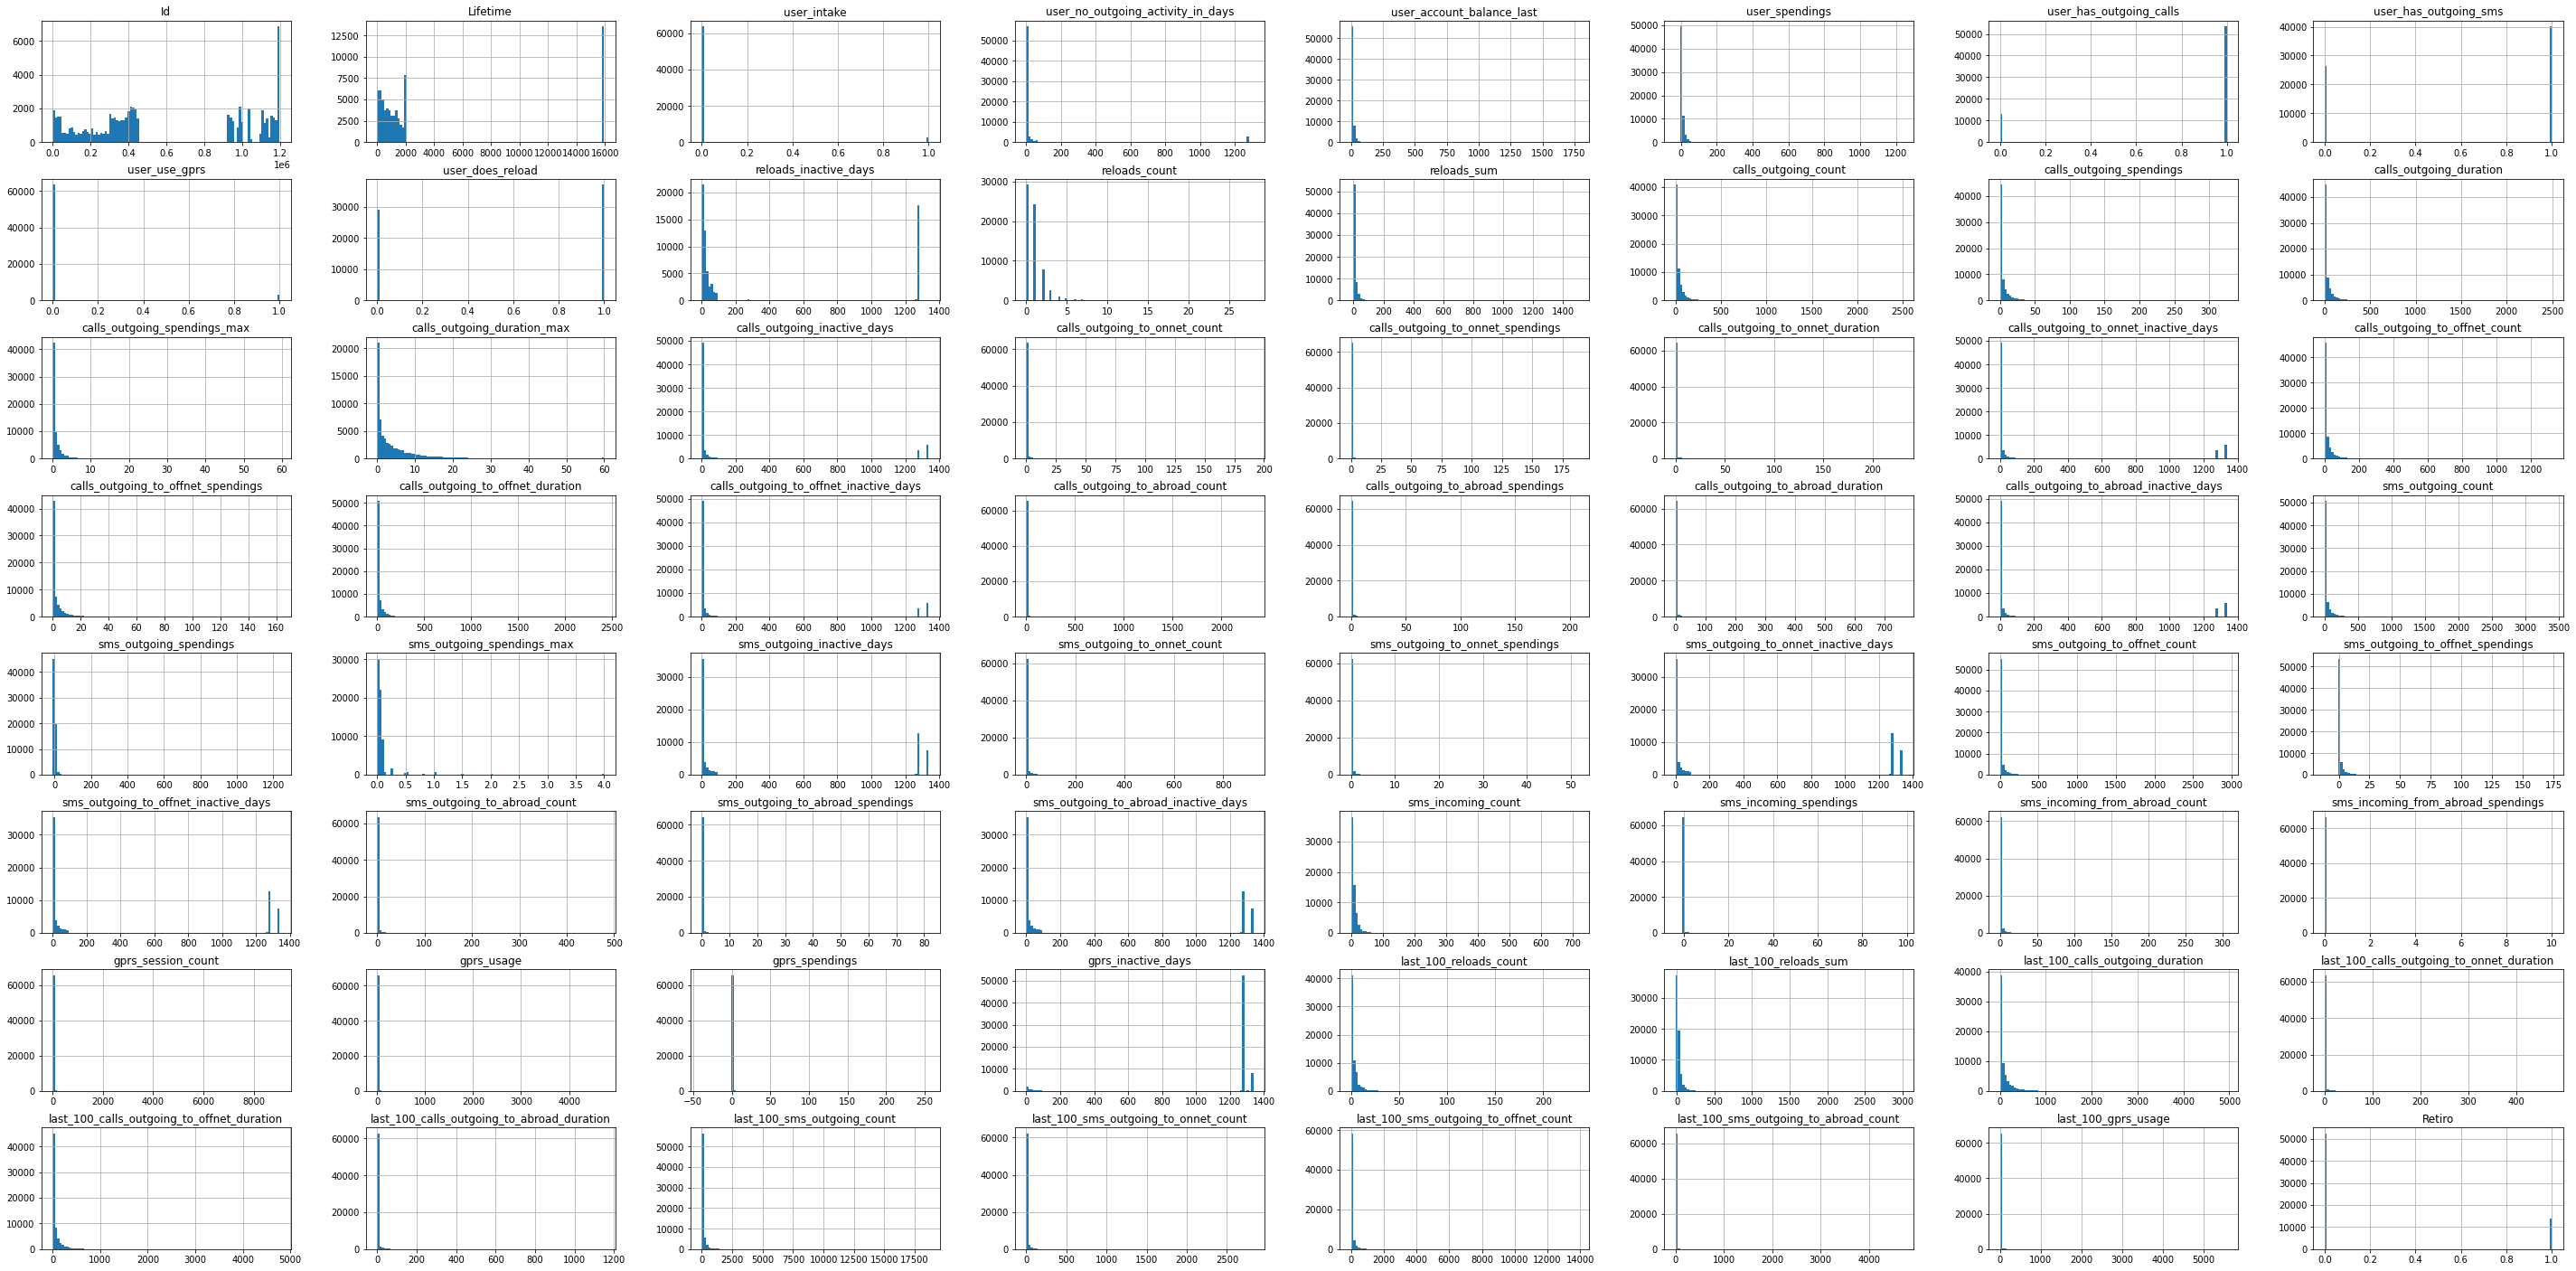

In [15]:
## Histogramas de frecuencia de todas las variables
%matplotlib inline
import matplotlib.pyplot as plt
BD.hist(bins=100, figsize=(50,25))
plt.show()

## Particion y preparacion de los datos



In [16]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Particion de los datos en conjunto de entrenamiento y conjunto de testeo
xtrain, xtest = train_test_split(BD, test_size=0.3, random_state=42)
print('Dimensions: , BD:',BD.shape,',train: ',xtrain.shape,',test: ',xtest.shape)
ytrain =xtrain["Retiro"].copy()
ytest  =xtest["Retiro"].copy()

xtrain=xtrain.drop("Retiro", axis=1) # Elimino la variable etiqeuta del coonjunto de entrenamiento
xtest=xtest.drop("Retiro", axis=1) # Elimino la variable etiqeuta del coonjunto de prueba
print('Dimensiones después de eliminar la salida para predecir a partir de los datos: , BD:',BD.shape,',train: ',xtrain.shape,',test: ',xtest.shape)

Dimensions: , BD: (66469, 64) ,train:  (46528, 64) ,test:  (19941, 64)
Dimensiones después de eliminar la salida para predecir a partir de los datos: , BD: (66469, 64) ,train:  (46528, 63) ,test:  (19941, 63)


### Observamos como nos queda la salida (ytrain) con la que se entrenara el modelo 

0    36866
1     9662
Name: Retiro, dtype: int64


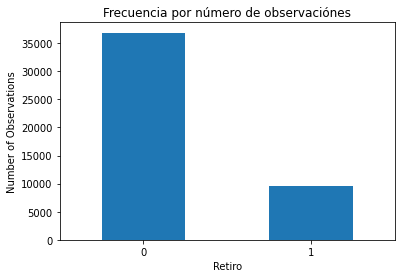

In [17]:
print(ytrain.value_counts())
count_classes = pd.value_counts(ytrain, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frecuencia por número de observaciónes")
plt.xlabel("Retiro")
plt.ylabel("Number of Observations");

En la celda anterior podemos ver que las etiquetas con las que sera entrenado el modelo estan desequilibradas, ya que hay muchos mas clientes que no desertan comparados con los que desertan. Por este motivo el modelo va tener problemas a la hora de predecir la etiqueta 1, es decir cuando hay deserción.

Para evitar esto penalizaremos la clase 0 en la etiqueta de salida con el fin de darle mas peso a la etiqueta 1 y que asi el modelo sea mucho mas estable y acertado.

Para esto usamos una funcion ya implementada en la libreria Sklearn la cual se encarga de evaluar el desvalance de las etiquetas y dar un peso sugerido para cada una de ellas.

In [18]:
#Sugerencia para los pesos de las etiquetas
from sklearn.utils import class_weight
class_w = class_weight.compute_class_weight('balanced',np.unique(ytrain),ytrain)
print(class_w)

[0.63104215 2.40778307]


Ahora tenemos ya casi todo listo para seleccionar y entrenar nustro modelo predictor, pero antes debemos depurar y estandarizar el dataset. para esto usamos PCA para reduzir las dimensiones del Dataset y representar mucho mejor los datos y Standar Scaler para estandarizar las caracteristicas eliminando la media y escalando a varianza unitaria

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

#Preproceso de normalizacion
def PC(Y): # Funcion para el proceso de PCA de los datos
  pca = PCA()
  pca.fit(Y)
  Z= pca.transform(Y)
  return Z

## Normalizacion
stdcaler=StandardScaler()
stdcaler.fit(xtrain)
x_train=stdcaler.transform(xtrain)
x_test=stdcaler.transform(xtest)

## PCA
pca = PCA()
pca.fit(x_train)
x_train_=pca.transform(x_train)
x_test_=pca.transform(x_test)


## Seleccion y entrenamiento del modelo

Al ser un problema de calisifcacion binaria (1 o 0) se podria usar cualquier tipo de clasificador ( Bayes, SVMS, Random Forest...) sin embargo para tareas de clasificacion como estas, las redes neuronales funcionan muy bien, son muy eficientes y sencillas de entrenar. 

Por esto decidimos usar una red neuronal sencilla con 3 capas profundas y una de salida.

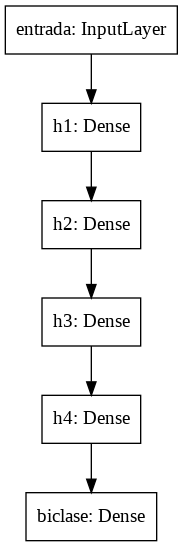

In [57]:
# Definicion de la arquitectura
import tensorflow as tf
tf.keras.backend.clear_session()

#Constantes para regularizacion
l1=1e-3
l2=1e-3

inputA = tf.keras.layers.Input(shape=(x_train_.shape[1]), name='entrada')
h1 = tf.keras.layers.Dense(300,activation='tanh',name='h1',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(inputA)
h2 = tf.keras.layers.Dense(500,activation='tanh',name='h2',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1)
h3 = tf.keras.layers.Dense(200,activation='tanh',name='h3',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h2)
h4 = tf.keras.layers.Dense(50,activation='tanh',name='h4',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h3)
outputA = tf.keras.layers.Dense(1,activation="sigmoid",name='biclase')(h4)
model_fun = tf.keras.Model(inputs=inputA,outputs=outputA)
tf.keras.utils.plot_model(model_fun)
#Se usa activacion tanh, su salida va de -1 a 1

In [58]:
model_fun.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 300)               19200     
_________________________________________________________________
h2 (Dense)                   (None, 500)               150500    
_________________________________________________________________
h3 (Dense)                   (None, 200)               100200    
_________________________________________________________________
h4 (Dense)                   (None, 50)                10050     
_________________________________________________________________
biclase (Dense)              (None, 1)                 51        
Total params: 280,001
Trainable params: 280,001
Non-trainable params: 0
_______________________________________________________

In [59]:
## Definicion de parametros
model_fun.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=tf.keras.losses.BinaryCrossentropy(), # funcion de perdida de la neurona
                  metrics='accuracy')                        # Metrica de medicion seleccionada

# Penalizacion de las clases de la etiqeuta

class_w={0: 0.62654,1: 2.40778307}

## Entrenamiento de la neurona
history = model_fun.fit(x =x_train_, y=ytrain, 
                        epochs=30,batch_size=32,
                    validation_split=0.3,
                  class_weight=class_w)


Epoch 1/30
1018/1018 [==============================] - 9s 8ms/step - loss: 10.4234 - accuracy: 0.8240 - val_loss: 2.2749 - val_accuracy: 0.8243
Epoch 2/30
1018/1018 [==============================] - 8s 8ms/step - loss: 1.5860 - accuracy: 0.8305 - val_loss: 0.7063 - val_accuracy: 0.8297
Epoch 3/30
1018/1018 [==============================] - 8s 8ms/step - loss: 0.6338 - accuracy: 0.8346 - val_loss: 0.5340 - val_accuracy: 0.8318
Epoch 4/30
1018/1018 [==============================] - 8s 8ms/step - loss: 0.5190 - accuracy: 0.8359 - val_loss: 0.5002 - val_accuracy: 0.8292
Epoch 5/30
1018/1018 [==============================] - 8s 8ms/step - loss: 0.4892 - accuracy: 0.8338 - val_loss: 0.4921 - val_accuracy: 0.8251
Epoch 6/30
1018/1018 [==============================] - 8s 8ms/step - loss: 0.4784 - accuracy: 0.8325 - val_loss: 0.4761 - val_accuracy: 0.8279
Epoch 7/30
1018/1018 [==============================] - 8s 8ms/step - loss: 0.4700 - accuracy: 0.8351 - val_loss: 0.4733 - val_accuracy

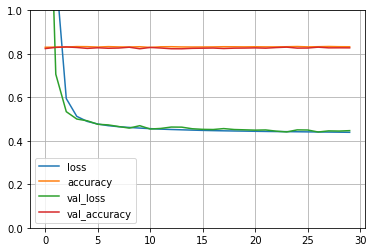

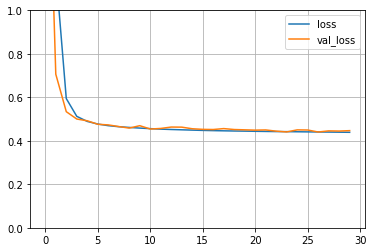

In [60]:
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

hpd[['loss','val_loss']].plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

En las graficas anteriores podemos apreciar las metricas de medicion del modelo:

* **val_loss**: Es el porcentaje de perdida sobre conjunto de validacion

* **loss**: Es el porcentaje de perdida sobre conjunto de entrenamiento

* **accuracy**: se refiere a lo cerca que está el resultado de una medición del valor verdadero. En términos estadísticos, el accuracy está relacionada con el sesgo de una estimación, en este caso sobre el conjunto de datos de entrenamiento

* **val_accuracy**: Es la misma medida de accuracy pero sobre los datos de validacion 





### La martriz de confusion (Evaluacion del modelo)

Es una herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases.

En este caso la matriz de confusion es una matriz cuadrada de solo dos columnas y dos filas.
las filas representan los valores reales, mientras que las columanas representan los valores predichos por el algoritmo.

la primera fila representa los ceros (0) reales que indican que el cliente no se se fue de la empresa, mientras que la segunda fila representa los unos (1) reales que indican que el cliente decerto de la empresa.

Analogamente la primera columna representa los ceros (0) y la segunda los unos (1) predichos por el algoritmo. El resultado ideal seria una matriz identidad con los valores exactamente a los reales en la diagonal.

Como se puede observar la matriz de confusion nos muestra que el algoritmo es bastante estable y al momento de predecir tiene una exactitud del 83% para los 1 y 82% para los 0, Analogamente el algoritmo entrenado tiene un accuracy del 83% sobre los datos de validacion (datos que no ve al momento de ser entrenado).

Abajo de la matriz de confusion podemos ver los valores reales totales de ceros (0) y unos (1), lo que nos permite ver que el algoritmo no tiene datos nulos, vacios y/o perdidos.


(19941, 1)
[0. 1.]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     15696
           1       0.57      0.82      0.68      4245

    accuracy                           0.83     19941
   macro avg       0.76      0.83      0.78     19941
weighted avg       0.87      0.83      0.84     19941



0    52562
1    13907
Name: Retiro, dtype: int64

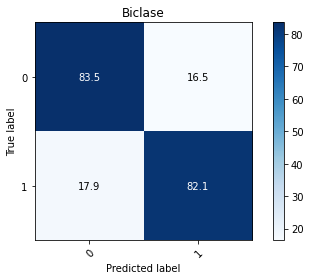

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

ytest_e= model_fun.predict(x_test_)
print(ytest_e.shape)
print(np.unique(np.round(ytest_e)))
plot_confusion_matrix(ytest, np.round(ytest_e),classes=np.unique(ytest))
plt.title('Biclase')
print(classification_report(ytest, np.round(ytest_e)))
BD["Retiro"].value_counts()


Paranoico para la clase 1 (Desercion del cliente )

(63,)


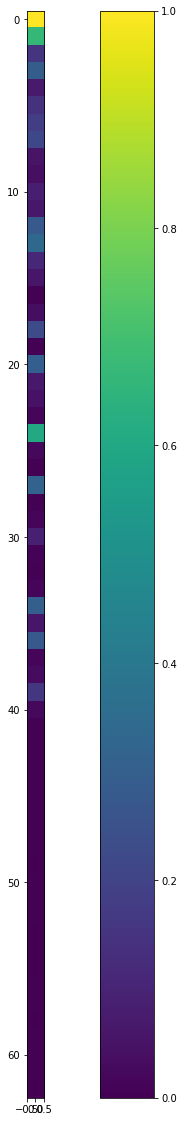

In [62]:
## Peso de las variables para la red neuronal
W1 = abs(model_fun.get_layer('h1').get_weights()[0]).sum(axis=1)
print(W1.shape)
Wc = np.c_[W1]
Wc /=np.max(Wc)
plt.figure(figsize=(20,20))
plt.imshow(Wc,vmin=0,vmax=1)
plt.colorbar()
plt.show()

En el grafico anterior podemos ver el peso de las 63 variables del dataset sobre la decision que toma la red neuronal. La grafica de la izquierda representa las 63 variables con su respectivo peso para la red neuronal, mientras que la grafica de la derecha simplemente es una muestra de como se clasifica el nivel de importancia de cada una de las variables ( 0 a 1 ) donde el color morado oscuro es significa muy poca importancia y el amarillo la mayor importancia posible.

En ese orden de ideas, vemos algunas de las variables mas relevantes para la red neuronal

In [63]:
## Variables mas relevantes para la prediccion 
print(xtrain.iloc[:,1])
print(xtrain.iloc[:,3])
print(xtrain.iloc[:,6])
print(xtrain.iloc[:,12])
print(xtrain.iloc[:,13])
print(xtrain.iloc[:,18])
print(xtrain.iloc[:,20])
print(xtrain.iloc[:,24])
print(xtrain.iloc[:,34])
print(xtrain.iloc[:,36])
print(xtrain.iloc[:,39])

34729     335
56012      58
1398      799
26182    1231
24033    1284
         ... 
37194     464
6265      858
54886     172
860       860
15795    1768
Name: Lifetime, Length: 46528, dtype: int64
34729     3
56012    19
1398      3
26182     9
24033     7
         ..
37194     2
6265      1
54886     1
860       1
15795     7
Name: user_no_outgoing_activity_in_days, Length: 46528, dtype: int64
34729    1
56012    1
1398     1
26182    1
24033    1
        ..
37194    1
6265     1
54886    1
860      1
15795    1
Name: user_has_outgoing_calls, Length: 46528, dtype: int64
34729     5.00
56012     0.00
1398      0.00
26182    12.00
24033     0.00
         ...  
37194    13.51
6265      7.51
54886    20.00
860       0.00
15795     0.00
Name: reloads_sum, Length: 46528, dtype: float64
34729     25
56012      6
1398      39
26182     51
24033     24
        ... 
37194     68
6265      19
54886    153
860        9
15795      4
Name: calls_outgoing_count, Length: 46528, dtype: int64
34729   


Una vez satisfechos con la precisión de validación del modelo,  se debe evaluarla en el conjunto de prueba para estimar el error de generalización antes de implementar el modelo en producción:

In [64]:
model_fun.evaluate(x_test_, ytest)

624/624 [==============================] - 2s 3ms/step - loss: 0.4404 - accuracy: 0.8325


[0.440383642911911, 0.8325058817863464]

es común obtener un rendimiento ligeramente inferior en el conjunto de prueba que en el conjunto de validación, porque los hiperparámetros están sintonizados en el conjunto de validación, no en el conjunto de prueba. Sin embargo, vemos que el modelo tiene un muy buen comportamiento sobre el conjunto de prueba con un **Accuracy del 83%**


## Usando el modelo para hacer predicciones
A continuación, podemos usar el método predict() del modelo para hacer predicciones sobre nuevas instancias. Como no tenemos instancias nuevas reales, solo usaremos las primeras 5 instancias del conjunto de prueba:

In [65]:
X_new = xtest[:5]
y_proba = model_fun.predict(X_new)
y_proba.round(0)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

Ahora miraremos en las etiquetas originales, que valor tenia cada uno de los 5 registros seleccionados como nuevas instancias

In [66]:
#Estiqueta Originale de los 5 primeros registros
y_new = ytest[:10]
y_new

25455    0
37797    0
31491    0
20412    0
60495    0
6205     0
17449    0
23000    0
5011     0
17779    0
Name: Retiro, dtype: int64

Como podemos ver, el modelo ha clasificado y predicho correctamente las 5 instancias nuevas ingresadas. 

## Guardado y puesta en produccion de la red neuronal

In [68]:
# serializar el modelo a JSON
model_json = model_fun.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model_fun.save_weights("model.h5")
print("Modelo Guardado!")

Modelo Guardado!


Carga del modelo guardado

In [75]:
import json
import keras
# cargar json y crear el modelo
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# cargar pesos al nuevo modelo
loaded_model.load_weights("model.h5")
print("Cargado modelo desde disco.")

Cargado modelo desde disco.


Predicciones con el modelo cargado desde disco

In [77]:
# Compilar modelo cargado y listo para usar.
loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

#Predicciones
loaded_model.predict(xtest).round(0)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

**Daniel Cardona Velasquez.**

**Ingeniero Electronico.**

**Especialista en Inteligencia Artifiial ( En proceso )**

**Universidad Nacional De Colombia.**

**Todos los derechos reservados.**